In [1]:
# Imports

import sys
sys.path.append('../python/')
import NGC5533_functions as nf
import numpy as np
import matplotlib.pyplot as plt
import lmfit as lm
import dataPython as dp

In [2]:
# Importing data
#SPARC is a database of 175 late-type galaxies (spirals and irregulars) with Spitzer photometry 
#at 3.6 mu (tracing the stellar mass distribution) and high-quality HI+Halpha rotation curves 
#(tracing the gravitational potential out to large radii).
#http://astroweb.cwru.edu/SPARC/

data = dp.getXYdata_wYerr('UGC2953.txt')
r_dat = np.asarray(data['xx'])
v_dat = np.asarray(data['yy'])
#v_err0 = np.asarray(data['ex'])
v_err1 = np.asarray(data['ey'])

#Express as weights
weighdata = 1/(np.sqrt(v_err1**2))

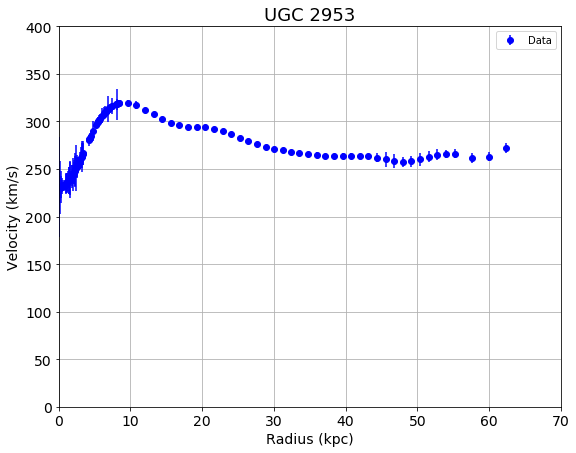

In [3]:
# Plotting Rotational Velocities

fig = plt.figure(figsize=(9,7))

ax = plt.axes()
ax.grid(True)

plt.xlim(0,70)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')

ax.set_title('UGC 2953', fontsize=18)             
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend()
plt.show()

In [4]:
# Fitting
# Function for fitting only prefactors + halo's parameters + data thief
def f(r,M,rc,rho00,c,pref,gpref):
    return np.sqrt(nf.bh_v(r,M,load=True,path='../fitting')**2 
                   + nf.h_v(r,rc,rho00,load=True,path='../fitting')**2 
                   + c**2 * nf.b_v(r,load=True,path='../fitting')**2 
                   + pref**2 * nf.d_thief(r)**2
                   + gpref**2 * nf.g_thief(r)**2)

In [5]:
# Fit

#Setup
f_mod = lm.Model(f)
f_params = f_mod.make_params()

#Black Hole
f_params.add('M', value=nf.Mbh_def, min=1.0e8)     #Mass

#Halo
f_params.add('rc', value=nf.h_rc, min=0.1)         #Core Radius
f_params.add('rho00', value=nf.hrho00_c, min=0)    #Density

#Bulge
f_params.add('c', value=1,min=0,max=100)           #Prefactor

#Disk
f_params.add('pref', value=1,min=0, max=100)       #Prefactor

#Gas
f_params.add('gpref', value=1,min=.8, max=1.2)     #Prefactor

#Do fit
f_fit = f_mod.fit(v_dat,f_params,r=r_dat,weights=weighdata)

In [6]:
print('Fit information:')
f_fit

Fit information:


In [7]:
bestf = f_fit.best_fit

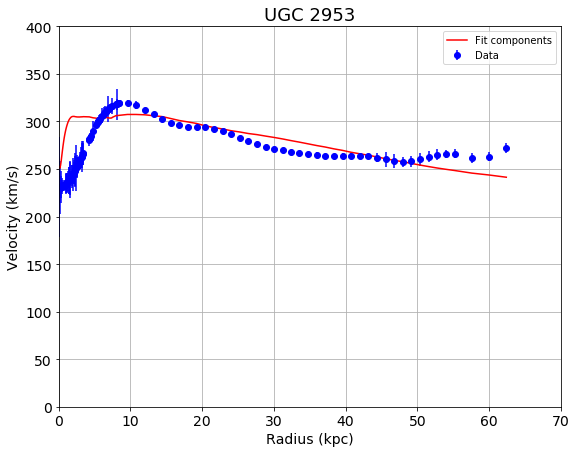

In [8]:
# Plot

fig = plt.figure(figsize=(9,7))

ax = plt.axes()
ax.grid(True)

plt.xlim(0,70)
plt.ylim(0,400)

plt.errorbar(r_dat,v_dat,yerr=v_err1,fmt='bo',label='Data')
plt.plot(r_dat,bestf,'r-',label='Fit components')

ax.set_title('UGC 2953', fontsize=18)             
ax.set_xlabel('Radius (kpc)', fontsize=14)
ax.set_ylabel('Velocity (km/s)', fontsize=14)
ax.xaxis.set_tick_params(labelsize=14)
ax.yaxis.set_tick_params(labelsize=14);

plt.legend()
plt.show()